## Stable Diffusion fine tune with DreamBooth on SageMaker notebook
* Tested with ml.g5.2xlarge SageMaker notebook, which has a NVIDIA A10G GPU with 24 GiB GPU memory.
* Content included training part and inference part.
* If you tend to optimize GPU with less memory used, refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)
* Major training codes were borrowed from [Huggingface's repo](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) and most of inference codes were borrowed from [Philschmid's blog](https://www.philschmid.de/sagemaker-stable-diffusion).

## 1. SageMaker training part

### 1.1 Install dependencies

In [1]:
!pip install -U pip
!pip install -U torch==1.13.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/huggingface/diffusers.git

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-jy0x1qas
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-jy0x1qas
  Resolved https://github.com/huggingface/diffusers.git to commit aba2a65d6ab47c0d1c12fa47e9b238c1d3e34512
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
%%writefile requirements.txt
accelerate
torchvision
transformers>=4.25.1
ftfy
tensorboard
modelcards
bitsandbytes==0.35.4  # newly updated version of bitsandbytes made images into garbage, so freeze the version for now
datasets  # huggingface diffusers repo's bug for missing implementation of datasets

Writing requirements.txt


In [3]:
!pip install -U -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### 1.2 Initialize an Accelerate environment 

In [4]:
from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /home/ec2-user/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

### 1.3 Get training scripts from HuggingFace Diffusers repo

In [5]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

### 1.4 Train a modle for generating NIKKE Anis images
* "Person(avatar)" training example, you can also train the model for "style" or "object"  
* More information you can refer to [DreamBooth example of Huggingface Diffusers](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth)

In [6]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/tuk/source"
CLASS_DATA_DIR = "images/tuk/class"
IMAGES_OUTPTS = "images/outputs"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $CLASS_DATA_DIR $IMAGES_OUTPTS

In [7]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/tuk/source/* $INSTANCE_DATA_DIR
# you can generate your own class images during training
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/tuk/class/* $CLASS_DATA_DIR 

Cloning into 'dreambooth-stablediffusion-sagemaker-notebook'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (292/292), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 292 (delta 31), reused 276 (delta 15), pack-reused 0
Receiving objects: 100% (292/292), 18.56 MiB | 62.52 MiB/s, done.
Resolving deltas: 100% (31/31), done.
cp: cannot stat ‘dreambooth-stablediffusion-sagemaker-notebook/images/tuk/class/*’: No such file or directory


In [8]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of avdtuk avatar girl" \
  --class_prompt="photo of avatar girl" \
  --resolution=512 \
  --train_batch_size=1 \
  --use_8bit_adam \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=1000

01/08/2023 19:37:49 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no

Fetching 15 files: 100%|█████████████████████| 15/15 [00:00<00:00, 33788.70it/s]
{'requires_safety_checker'} was not found in config. Values will be initialized to default values.
{'prediction_type'} was not found in config. Values will be initialized to default values.
{'class_embed_type', 'dual_cross_attention', 'num_class_embeds', 'use_linear_projection', 'mid_block_type', 'resnet_time_scale_shift', 'upcast_attention', 'only_cross_attention'} was not found in config. Values will be initialized to default values.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open t

### 1.5 Mode inference testing

  0%|          | 0/20 [00:00<?, ?it/s]

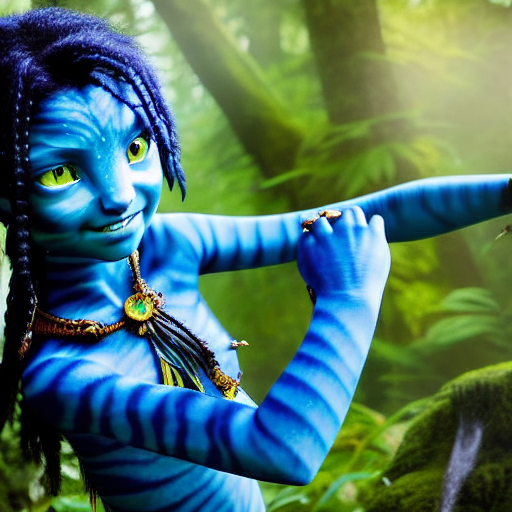

images/outputs/6389979383797864_2023-01-08 20:07:34.png



  0%|          | 0/20 [00:00<?, ?it/s]

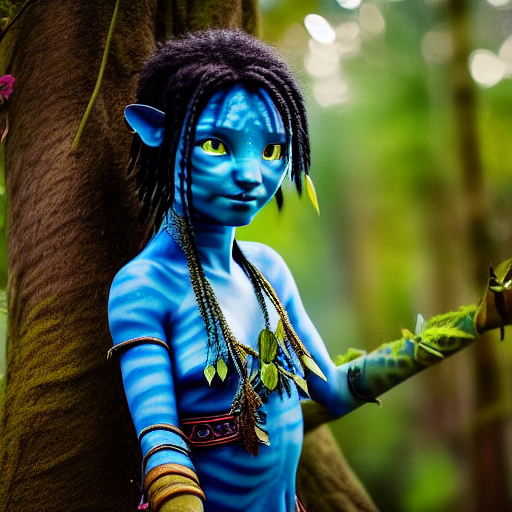

images/outputs/5912520272989581_2023-01-08 20:07:36.png



  0%|          | 0/20 [00:00<?, ?it/s]

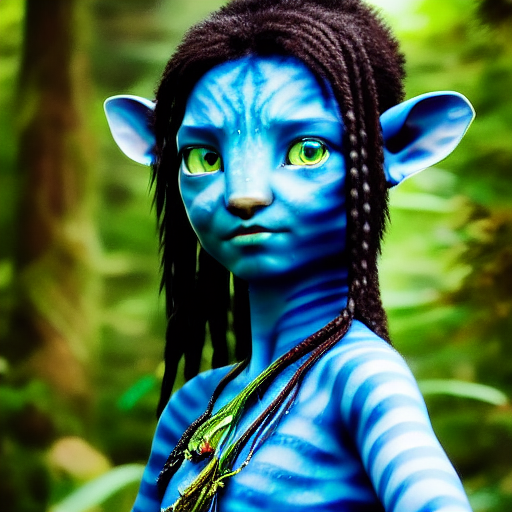

images/outputs/7586966264054060_2023-01-08 20:07:38.png



  0%|          | 0/20 [00:00<?, ?it/s]

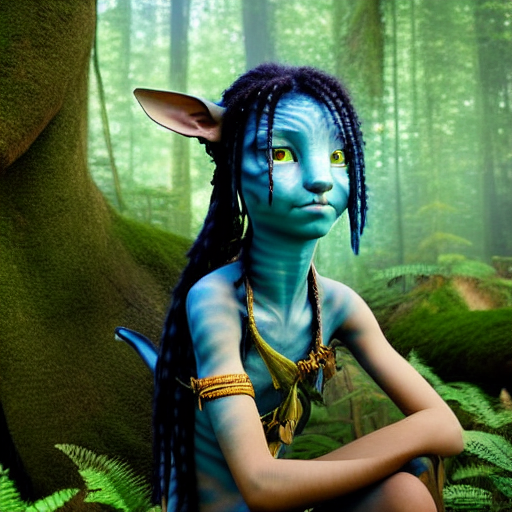

images/outputs/5031518415411287_2023-01-08 20:07:40.png


Seeds for generating images: [6389979383797864, 5912520272989581, 7586966264054060, 5031518415411287]



In [9]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = OUTPUT_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Uncomment below codes, if you don't want to enable NFSW
# def dummy(images, **kwargs):
#     return images, False
# pipe.safety_checker = dummy

prompt = "photo of avdtuk avatar girl, nice detailed face, forest background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 4
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

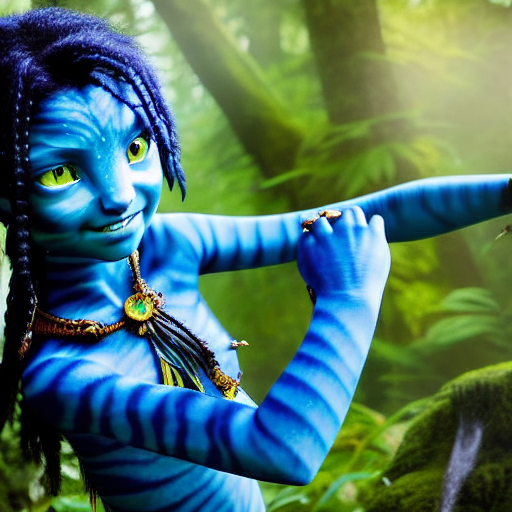

In [10]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

### 1.6 Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111
* For how to use "Stable Diffusion web UI" of AUTOMATIC1111, please refer to this repo
* DreamBooth plugin can also be implemented for "Stable Diffusion web UI" to fine tune the model
* You can also use other methods provided by webUI to fine tune the model.

In [11]:
# !wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# ckpt_path = OUTPUT_DIR + "/model.ckpt"
# half_arg = ""
# # Whether to convert to fp16, takes half the space (2GB).
# fp16 = False # {type: "boolean"}
# if fp16:
#     half_arg = "--half"
# !python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
# print(f"[*] Converted ckpt saved at {ckpt_path}")